In [207]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Split the dataset into training and testing sets

In [208]:
# load and organize data 
data_folder = "/users/chris/pythonML/data_folder"
emotions = ["sad", "angry", "happy", "fear"] 

data = [] # empty list to store data

# iterate through each emotion category
for emotion in emotions:
    # creates path to specific emotion folder
    emotion_dir = os.path.join(data_folder, emotion)
    # iterate through every file in the emotion folder
    for file in os.listdir(emotion_dir):
        # if it's an audio file, add it to data list
        if file.endswith(".wav"):
            data.append({
                "emotion": emotion,
                "filepath": os.path.join(emotion_dir, file)
            })

data_df = pd.DataFrame(data) # convert list to data frame
print("Data DataFrame:\n", data_df.head())
print("Sample count for each emotion:\n", data_df["emotion"].value_counts())

Data DataFrame:
   emotion                                           filepath
0     sad  /users/chris/pythonML/data_folder/sad/YAF_turn...
1     sad  /users/chris/pythonML/data_folder/sad/YAF_pad_...
2     sad  /users/chris/pythonML/data_folder/sad/YAF_yes_...
3     sad  /users/chris/pythonML/data_folder/sad/YAF_pike...
4     sad  /users/chris/pythonML/data_folder/sad/YAF_sure...
Sample count for each emotion:
 sad      100
happy    100
angry    100
fear     100
Name: emotion, dtype: int64


In [209]:
# split the dataset into training and testing sets
train_data = []
test_data = []

# iterate through each emotion category
for emotion in emotions:
    # filter data for current emotion
    emotion_data = data_df[data_df["emotion"] == emotion]
    # split the current emotion into 70% training and 30% testing
    train, test = train_test_split(emotion_data, test_size=0.3, random_state=42)
    # add to respective lists
    train_data.append(train)
    test_data.append(test)

# add data from all emotions into a single datframe for train and test
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

print("Training sample count for each emotion:\n", train_df["emotion"].value_counts())
print("Testing sample count for each emotion:\n", test_df["emotion"].value_counts())

Training sample count for each emotion:
 angry    70
fear     70
sad      70
happy    70
Name: emotion, dtype: int64
Testing sample count for each emotion:
 sad      30
angry    30
fear     30
happy    30
Name: emotion, dtype: int64


# Step 2: Exploratory Data Analysis

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np

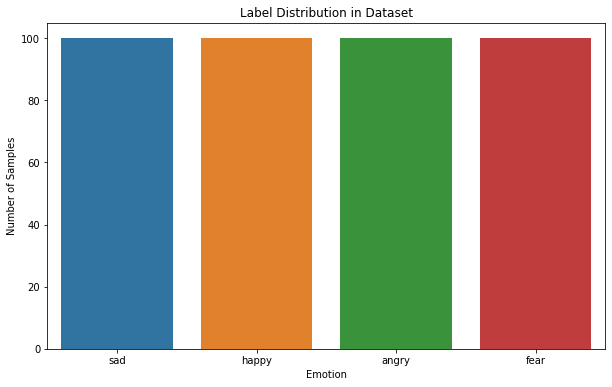

In [211]:
# Count the number of samples for each emotion
label_counts = data_df["emotion"].value_counts()

# Plot the label distribution as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.show()

In [212]:
# Select a random sample from the dataset for exploration
sample = data_df.sample(1).iloc[0]
audio, sr = librosa.load(sample["filepath"]) # load sample to librosa

In [213]:
from IPython.display import Audio
Audio(sample["filepath"]) # allow audio to be played

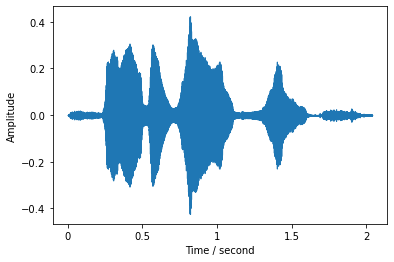

In [214]:
# plot audio file on time domain
plt.figure(1)
librosa.display.waveshow(y=audio, sr=sr)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

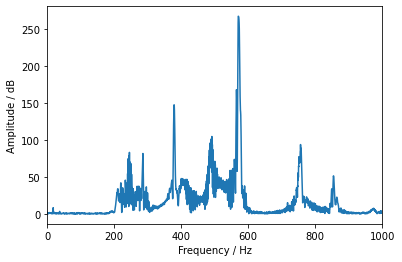

In [215]:
# plot audio files in frequency domain
k = np.arange(len(audio))
T = len(audio)/sr
freq = k/T

DATA_0 = np.fft.fft(audio)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz") # set x axis
plt.ylabel("Amplitude / dB") # set y axis
plt.xlim([0, 1000])
plt.show()

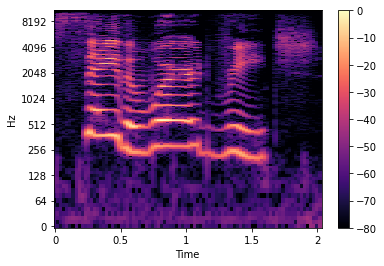

In [216]:
# plot the time-frequency variation of the audio
D = librosa.stft(audio)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# Step 3: Acoustic Feature Extraction

In [217]:
import pandas as pd

In [245]:
def extract_features(filepath):
    audio, sr = librosa.load(filepath)
    
    # Feature extraction: Loudness
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(audio))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    
    # Feature extraction: mel-frequency cepstral coefficients
    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=12)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
    
    # Feature extraction: zero crossing rate
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    
    # Feature extraction: chroma
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
    
    # Feature extraction: mel spectogram
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
    
    # Find the maximum length among all DataFrames
    max_len = max(len(df_loudness), len(df_mfccs), len(df_zero_crossing_rate), len(df_chroma), len(df_mel_spectrogram))

    # Pad the shorter DataFrames with zeros
    df_loudness = df_loudness.reindex(range(max_len), fill_value=0)
    df_mfccs = df_mfccs.reindex(range(max_len), fill_value=0)
    df_zero_crossing_rate = df_zero_crossing_rate.reindex(range(max_len), fill_value=0)
    df_chroma = df_chroma.reindex(range(max_len), fill_value=0)
    df_mel_spectrogram = df_mel_spectrogram.reindex(range(max_len), fill_value=0)

    # Combine all features
    feature_matrix = pd.concat([df_loudness, df_mfccs, df_zero_crossing_rate, df_chroma, df_mel_spectrogram], axis=1)
    return feature_matrix

In [246]:
# Extract features for each audio file in the training set
train_features = pd.concat([extract_features(row["filepath"]) for _, row in train_df.iterrows()], axis=0, ignore_index=True)
train_labels = train_df["emotion"].values

# Extract features for each audio file in the testing set
test_features = pd.concat([extract_features(row["filepath"]) for _, row in test_df.iterrows()], axis=0, ignore_index=True)
test_labels = test_df["emotion"].values

# Check NaN values in train_features and test_features
print("Number of NaN values in train_features:", train_features.isna().sum().sum())
print("Number of NaN values in test_features:", test_features.isna().sum().sum())

Number of NaN values in train_features: 0
Number of NaN values in test_features: 0


# Step 4: Feature Post-processing

In [247]:
from sklearn.preprocessing import MinMaxScaler

In [248]:
# Feature Matrix Scaling
# Initialize the MinMaxScaler with a range of -1 to 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training features and transform them
train_features_minmax = min_max_scaler.fit_transform(train_features)

# Transform the testing features using the same scaler
test_features_minmax = min_max_scaler.transform(test_features)

In [249]:
# function used for averaging features
def average_features_over_time(df, window_length_frames=10):    
    # Calculate the number of windows
    num_windows = len(df) // window_length_frames
    
    # If there is not enough data for at least one window, return a DataFrame with NaN values
    if num_windows == 0:
        return pd.DataFrame(np.nan, index=[0], columns=df.columns)
    
    # Truncate the DataFrame to the exact number of windows
    truncated_df = df.iloc[:num_windows * window_length_frames, :]
    
    # Reshape the DataFrame
    reshaped_df = truncated_df.values.reshape(num_windows, window_length_frames, -1)
    
    # Calculate the mean along the time axis
    averaged_df = reshaped_df.mean(axis=1)
    
    return pd.DataFrame(averaged_df, columns=df.columns)

In [250]:
# Extract and average features for each audio file in the training set
train_features_averaged = pd.concat([average_features_over_time(extract_features(row["filepath"])).mean().to_frame().T for _, row in train_df.iterrows()], axis=0, ignore_index=True)
train_labels = train_df["emotion"].values

# Extract and average features for each audio file in the testing set
test_features_averaged = pd.concat([average_features_over_time(extract_features(row["filepath"])).mean().to_frame().T for _, row in test_df.iterrows()], axis=0, ignore_index=True)
test_labels = test_df["emotion"].values


# Step 5: Build your audio emotion recognition model

In [261]:
# import sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [262]:
print("Length of train_features_averaged:", len(train_features_averaged))
print("Length of train_labels:", len(train_labels))

Length of train_features_averaged: 280
Length of train_labels: 280


In [263]:
# Initialize a Random Forest classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the averaged training features and labels
rf_classifier.fit(train_features_averaged, train_labels)

# Predict the emotion labels for the testing features
test_predictions = rf_classifier.predict(test_features_averaged)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(test_labels, test_predictions))
print("Classification Report:\n", classification_report(test_labels, test_predictions))

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

       angry       0.90      0.90      0.90        30
        fear       0.84      0.90      0.87        30
       happy       0.96      0.83      0.89        30
         sad       0.91      0.97      0.94        30

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [264]:
# Initialize the SVM classifier with a RBF kernel
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the classifier on the averaged training features and labels
svm_classifier.fit(train_features_averaged, train_labels)

# Predict the emotion labels for the testing features
test_predictions_svm = svm_classifier.predict(test_features_averaged)

# Evaluate the classifier's performance
print("SVM Accuracy:", accuracy_score(test_labels, test_predictions_svm))
print("SVM Classification Report:\n", classification_report(test_labels, test_predictions_svm))

SVM Accuracy: 0.6
SVM Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.80      0.62        30
        fear       1.00      0.33      0.50        30
       happy       0.50      0.43      0.46        30
         sad       0.69      0.83      0.76        30

    accuracy                           0.60       120
   macro avg       0.67      0.60      0.58       120
weighted avg       0.67      0.60      0.58       120



In [265]:
# Initialize the KNN classifier with 5 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the averaged training features and labels
knn_classifier.fit(train_features_averaged, train_labels)

# Predict the emotion labels for the testing features
test_predictions_knn = knn_classifier.predict(test_features_averaged)

# Evaluate the classifier's performance
print("KNN Accuracy:", accuracy_score(test_labels, test_predictions_knn))
print("KNN Classification Report:\n", classification_report(test_labels, test_predictions_knn))

KNN Accuracy: 0.6083333333333333
KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.46      0.73      0.56        30
        fear       0.73      0.37      0.49        30
       happy       0.74      0.47      0.57        30
         sad       0.68      0.87      0.76        30

    accuracy                           0.61       120
   macro avg       0.65      0.61      0.60       120
weighted avg       0.65      0.61      0.60       120



In [266]:
# Initialize a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the averaged training features and labels
dt_classifier.fit(train_features_averaged, train_labels)

# Predict the emotion labels for the testing features
test_predictions_dt = dt_classifier.predict(test_features_averaged)

# Evaluate the classifier's performance
print("Decision Tree Accuracy:", accuracy_score(test_labels, test_predictions_dt))
print("Decision Tree Classification Report:\n", classification_report(test_labels, test_predictions_dt))

Decision Tree Accuracy: 0.75
Decision Tree Classification Report:
               precision    recall  f1-score   support

       angry       0.72      0.60      0.65        30
        fear       0.65      0.87      0.74        30
       happy       0.84      0.70      0.76        30
         sad       0.83      0.83      0.83        30

    accuracy                           0.75       120
   macro avg       0.76      0.75      0.75       120
weighted avg       0.76      0.75      0.75       120



In [267]:
# Initialize a Gradient Boosting Machines classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier on the averaged training features and labels
gbm_classifier.fit(train_features_averaged, train_labels)

# Predict the emotion labels for the testing features
test_predictions_gbm = gbm_classifier.predict(test_features_averaged)

# Evaluate the classifier's performance
print("Gradient Boosting Machines Accuracy:", accuracy_score(test_labels, test_predictions_gbm))
print("Gradient Boosting Machines Classification Report:\n", classification_report(test_labels, test_predictions_gbm))

Gradient Boosting Machines Accuracy: 0.9333333333333333
Gradient Boosting Machines Classification Report:
               precision    recall  f1-score   support

       angry       0.93      0.93      0.93        30
        fear       0.88      0.93      0.90        30
       happy       0.93      0.87      0.90        30
         sad       1.00      1.00      1.00        30

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120

